# **TECHNICAL DS TEST: Jérémie DONA**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, recall_score, precision_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
## Train-Test Split
from sklearn.model_selection import train_test_split

/Users/jeremiedona/Documents/venv/dl/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Load Data

In [3]:
train_set = pd.read_csv("/Users/jeremiedona/Documents/Descartes/data-scientist-technical-test/data/auto-insurance-fall-2017/train_auto.csv")
print(train_set.columns)
print(train_set.shape)

Index(['INDEX', 'TARGET_FLAG', 'TARGET_AMT', 'KIDSDRIV', 'AGE', 'HOMEKIDS',
       'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION',
       'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')
(8161, 26)


since there is no "target_flag" value in the other file, we will only use this one and split it accordingly.

In [4]:
# A FIRST VIEW AT THE DATA
pd.set_option('display.max_columns', None)
train_set.drop("TARGET_AMT", axis=1).head()

,INDEX,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


**ELEMENTARY DATA TRANSFORMATION**

In [5]:
from sklearn.preprocessing import KBinsDiscretizer as KB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def moneytoflt(x):
    """
        transform money str --> money float or nan
    """
    try:
        return float(str(x)[1:].replace(",", ""))
    except:
        # BCSE NANs
        return np.nan

def inputation(df, colname):
    """
           Inputs data where a nan is present with the median of the variable
    """
    med = np.median(df[colname].loc[1-np.isnan(df[colname])])
    train_set[colname].loc[np.isnan(train_set[colname])] = med 


def normalize(df, colname):
    """
        normalize column as x-mu/sigma to have an Normal range of value
    """
    #df[colname] = (df[colname] - df[colname].mean())/df[colname].std()

    #est = KB(n_bins=3, encode='ordinal', strategy='quantile')
    #est.fit(df[colname].values.reshape(-1, 1))
    est = StandardScaler().fit(df[colname].values.reshape(-1, 1))
    df[colname] = est.transform(df[colname].values.reshape(-1, 1))

def yestobool(x):
    if x.lower()=="yes":
        return 1
    else:
        return 0
    
def modeleval(Y_test, prediction):
    tn, fp, fn, tp = confusion_matrix(Y_test, prediction, labels=[0,1]).ravel()
    c = tn, fp, fn, tp

    recall = recall_score(Y_test, prediction)
    precision = precision_score(Y_test, prediction)
    accuracy = accuracy_score(Y_test, prediction)
    print(f" tn:{tn}, fp:{fp}, fn:{fn}, tp:{tp} \n")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"accuracy: {accuracy}")

In [6]:
# SIMPLE TRANSFORMATION
train_set["INCOME"] = train_set["INCOME"].apply(moneytoflt)
train_set["OLDCLAIM"] = train_set["OLDCLAIM"].apply(moneytoflt)
train_set["HOME_VAL"] = train_set["HOME_VAL"].apply(moneytoflt)
train_set["BLUEBOOK"] = train_set["BLUEBOOK"].apply(moneytoflt)

train_set["PARENT1"] = train_set["PARENT1"].apply(yestobool)
train_set["RED_CAR"] = train_set["RED_CAR"].apply(yestobool)
train_set["REVOKED"] = train_set["REVOKED"].apply(yestobool)
train_set["MSTATUS"] = train_set["MSTATUS"].apply(yestobool)

In [7]:
# DROP THE NA if not to costly
df = train_set.dropna()
print(f"percentage of data without na {df.shape[0]/train_set.shape[0]}")

percentage of data without na 0.7407180492586692


In [8]:
# TRANSFORM DUMMIES
df = pd.concat([df, pd.get_dummies(df["CAR_TYPE"])], axis=1)
df = pd.concat([df, pd.get_dummies(df["SEX"])],  axis=1)
df = pd.concat([df, pd.get_dummies(df["URBANICITY"])], axis= 1)
df = pd.concat([df, pd.get_dummies(df["JOB"])],  axis=1)
df = pd.concat([df, pd.get_dummies(df["EDUCATION"])],  axis=1)
df = pd.concat([df, pd.get_dummies(df["CAR_USE"])],  axis=1)

In [9]:
# DROP OLD COL
df.drop(columns="CAR_TYPE", axis=1, inplace=True)
df.drop(columns="URBANICITY", axis=1, inplace=True)
df.drop(columns="SEX", axis=1, inplace=True)
df.drop(columns="JOB",axis= 1, inplace=True)
df.drop(columns="EDUCATION", axis=1, inplace=True)
df.drop(columns="CAR_USE", axis=1, inplace=True)
df.drop(columns="INDEX", axis=1, inplace=True)

In [10]:
print(df.columns.values)
df.head()

['TARGET_FLAG' 'TARGET_AMT' 'KIDSDRIV' 'AGE' 'HOMEKIDS' 'YOJ' 'INCOME'
 'PARENT1' 'HOME_VAL' 'MSTATUS' 'TRAVTIME' 'BLUEBOOK' 'TIF' 'RED_CAR'
 'OLDCLAIM' 'CLM_FREQ' 'REVOKED' 'MVR_PTS' 'CAR_AGE' 'Minivan'
 'Panel Truck' 'Pickup' 'Sports Car' 'Van' 'z_SUV' 'M' 'z_F'
 'Highly Urban/ Urban' 'z_Highly Rural/ Rural' 'Clerical' 'Doctor'
 'Home Maker' 'Lawyer' 'Manager' 'Professional' 'Student' 'z_Blue Collar'
 '<High School' 'Bachelors' 'Masters' 'PhD' 'z_High School' 'Commercial'
 'Private']


,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,M,z_F,Highly Urban/ Urban,z_Highly Rural/ Rural,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar,<High School,Bachelors,Masters,PhD,z_High School,Commercial,Private
0,0,0.0,0,60.0,0,11.0,67349.0,0,0.0,0,14,14230.0,11,1,4461.0,2,0,3,18.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
1,0,0.0,0,43.0,0,11.0,91449.0,0,257252.0,0,22,14940.0,1,1,0.0,0,0,0,1.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
2,0,0.0,0,35.0,1,10.0,16039.0,0,124191.0,1,5,4010.0,4,0,38690.0,2,0,3,10.0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5,1,2946.0,0,34.0,1,12.0,125301.0,1,0.0,0,46,17430.0,1,0,0.0,0,0,0,7.0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
8,1,2501.0,0,34.0,0,10.0,62978.0,0,0.0,0,34,11200.0,1,0,0.0,0,0,0,1.0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


We begin an elementary data analysis in order to know more about our explanatory variable and their link to the variable to explain

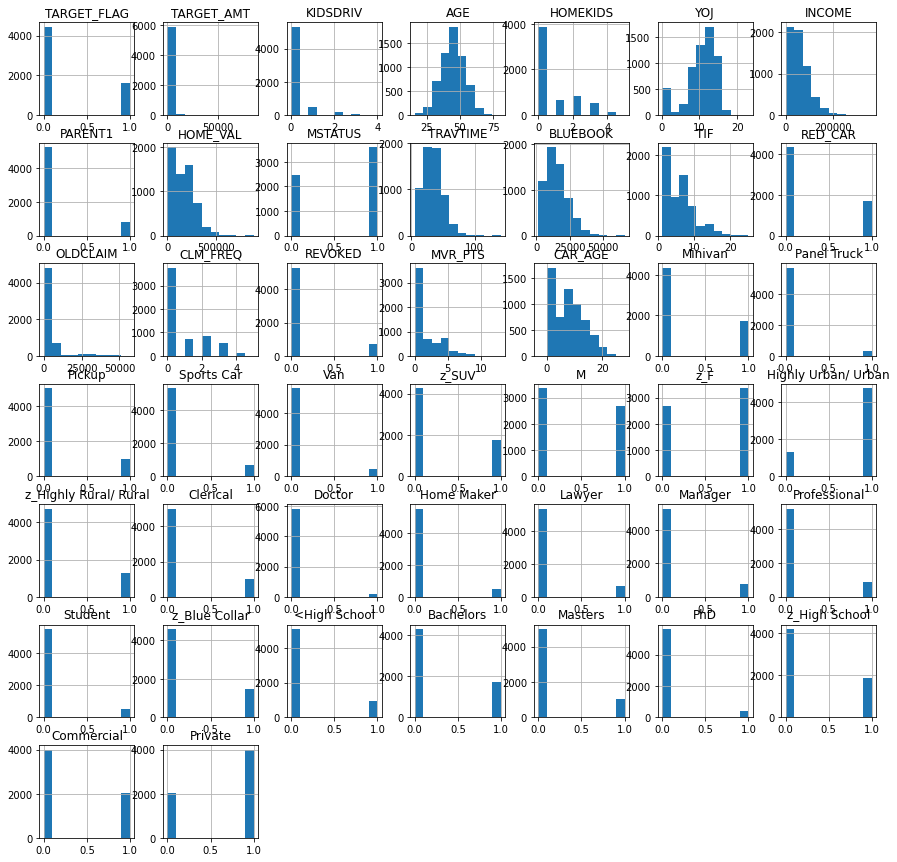

In [11]:
h=df.hist(figsize=(15, 15))

We first try to identify what could be driver for the variable to be explained: if the ratio is above 1 the amount,we have P(y|x)/ p(y) > 1, i.e P(y|x) > P(y)

In [12]:
## SOME ELEMENTARY VERIFICATIONS
prop = df["TARGET_FLAG"].mean()

print("\n")
print("KIDSDRIV",df[df["KIDSDRIV"]>=1]["TARGET_FLAG"].mean() / prop)
print("CLM_FREQ", df[df["CLM_FREQ"]>=1]["TARGET_FLAG"].mean() / prop)
print("REVOKED", df[df["REVOKED"]>=1]["TARGET_FLAG"].mean() / prop)
print("MVR_PTS", df[df["REVOKED"]>=1]["TARGET_FLAG"].mean() / prop)

print("\n")
print("MSTATUS", df[df["MSTATUS"]>=1]["TARGET_FLAG"].mean() / prop)
print("RED_CAR", df[df["MSTATUS"]>=1]["TARGET_FLAG"].mean() / prop)


print("\n")
print("Commercial", df[df["Commercial"]>=1]["TARGET_FLAG"].mean() / prop)
print("<High School", df[df["<High School"]>=1]["TARGET_FLAG"].mean() / prop)
print("z_High School", df[df["z_High School"]>=1]["TARGET_FLAG"].mean() / prop)
print("Bachelors", df[df["Bachelors"]>=1]["TARGET_FLAG"].mean() / prop)
print("PhD", df[df["PhD"]>=1]["TARGET_FLAG"].mean() / prop)


print("\n")
print("Highly Urban/ Urban", df[df['Highly Urban/ Urban']>=1]["TARGET_FLAG"].mean() / prop)
print("Highly Rural/ Rural", df[df['z_Highly Rural/ Rural']>=1]["TARGET_FLAG"].mean() / prop)


print("\n")
print("z_Blue Collar", df[df["z_Blue Collar"]>=1]["TARGET_FLAG"].mean() / prop)
print("Student", df[df["Student"]>=1]["TARGET_FLAG"].mean() / prop)
print("Manager", df[df["Manager"]>=1]["TARGET_FLAG"].mean() / prop)
print("Lawyer", df[df["Lawyer"]>=1]["TARGET_FLAG"].mean() / prop)
print("Home Maker", df[df["Home Maker"]>=1]["TARGET_FLAG"].mean() / prop)
print("Doctor", df[df["Doctor"]>=1]["TARGET_FLAG"].mean() / prop)
print("Clerical", df[df["Clerical"]>=1]["TARGET_FLAG"].mean() / prop)



print("\n")
print("Minivan", df[df["Minivan"]>=1]["TARGET_FLAG"].mean() / prop)
print("Sports Car", df[df["Sports Car"]>=1]["TARGET_FLAG"].mean() / prop)
print("z_SUV", df[df["z_SUV"]>=1]["TARGET_FLAG"].mean() / prop)
print("Panel Truck", df[df["Lawyer"]>=1]["TARGET_FLAG"].mean() / prop)
print("Pickup", df[df["Pickup"]>=1]["TARGET_FLAG"].mean() / prop)

print("\n")
print("M", df[df["M"]>=1]["TARGET_FLAG"].mean() / prop)
print("z_F", df[df["z_F"]>=1]["TARGET_FLAG"].mean() / prop)



KIDSDRIV 1.3796363004634384
CLM_FREQ 1.5417162274191383
REVOKED 1.6337947204064627
MVR_PTS 1.6337947204064627


MSTATUS 0.8193027064792863
RED_CAR 0.8193027064792863


Commercial 1.374334471616362
<High School 1.2367296115457773
z_High School 1.279975551394091
Bachelors 0.8717874208962935
PhD 0.6515237248403525


Highly Urban/ Urban 1.1976296752347237
Highly Rural/ Rural 0.27865168539325846


z_Blue Collar 1.3140459588116482
Student 1.4053661972813314
Manager 0.47954738861403995
Lawyer 0.7152579797641009
Home Maker 1.0369076361160119
Doctor 0.5094101123595506
Clerical 1.1419043363593762


Minivan 0.6100454238198725
Sports Car 1.2947969449952266
z_SUV 1.122912053363952
Panel Truck 0.7152579797641009
Pickup 1.2131470277537693


M 0.9552932252406012
z_F 1.0357494483488376


Some variable seem like good predictors (**[highly urban, sportscar, pickup, commerical, kidsdrive, claimfreq, student]**, or on the other hand **[PhD,  manager, lawyer, MINivan, REDCAR,MSTATUS]**) seem like grood predictor of the target_flag

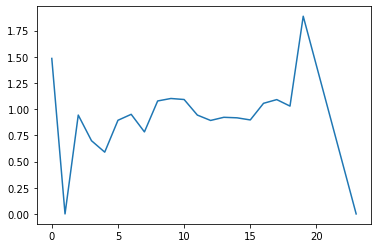

In [13]:
plt.plot(df.groupby("YOJ").mean()["TARGET_FLAG"]/ prop)

In [14]:
# WHITEN MONETARY VARIABELS
normalize(df, "INCOME")
normalize(df, "HOME_VAL")
normalize(df, "BLUEBOOK")
normalize(df, "OLDCLAIM")

In [15]:
# check if we are not undersampled
df["TARGET_FLAG"].mean()
# we are undersampled 

0.2650124069478908

The dataset shows an unbalance towards the label 0, i.e. positive values are under-represented.

In [16]:
# We begin by a very simple data analysis of correlation
df.corr()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,M,z_F,Highly Urban/ Urban,z_Highly Rural/ Rural,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar,<High School,Bachelors,Masters,PhD,z_High School,Commercial,Private
TARGET_FLAG,1.000000,0.541242,0.086933,-0.115274,0.111866,-0.066429,-0.148034,0.162017,-1.845159e-01,-0.131525,0.051459,-0.111521,-0.078885,-2.516496e-02,0.138721,0.228004,0.142795,0.230171,-0.110253,-0.146526,0.019402,0.057460,0.064783,-0.010080,0.047699,-0.024006,0.024006,0.226721,-0.226721,0.038639,-0.054492,0.006538,-0.060366,-0.120199,-0.042788,0.076003,0.107181,0.061573,-0.048945,-0.099694,-0.056958,0.112601,0.160423,-0.160423
TARGET_AMT,0.541242,1.000000,0.039043,-0.056546,0.053780,-0.024286,-0.062690,0.095154,-9.749983e-02,-0.093214,0.024283,-0.015724,-0.043934,-3.449673e-03,0.074603,0.113483,0.061262,0.140949,-0.069613,-0.086467,0.037344,0.020211,0.036666,0.014354,0.015135,0.002727,-0.002727,0.123812,-0.123812,0.003161,-0.035937,-0.003548,-0.031817,-0.074727,0.002987,0.021087,0.079566,0.040600,-0.013718,-0.057331,-0.026361,0.043025,0.104196,-0.104196
KIDSDRIV,0.086933,0.039043,1.000000,-0.066429,0.454167,0.051048,-0.031816,0.188811,-1.172042e-02,0.045769,-0.000443,-0.011378,0.000524,-3.352508e-02,0.022166,0.040624,0.037857,0.062978,-0.047095,-0.010432,-0.005659,0.011489,-0.009613,-0.031250,0.029240,-0.040837,0.040837,-0.027217,0.027217,0.030236,-0.042424,-0.002163,-0.038899,-0.021961,-0.024108,0.022554,0.042854,0.035724,-0.017986,-0.037772,-0.035748,0.040103,0.009958,-0.009958
AGE,-0.115274,-0.056546,-0.066429,1.000000,-0.445086,0.132253,0.183458,-0.316694,2.158415e-01,0.098247,0.009195,0.156458,0.002110,1.698497e-02,-0.026570,-0.030659,-0.035284,-0.078043,0.190253,0.019562,0.020658,-0.046641,0.030922,0.021782,-0.026517,0.062553,-0.062553,0.043143,-0.043143,-0.160579,0.119215,0.010769,0.151418,0.099144,0.045862,-0.126245,-0.057652,-0.128571,-0.002078,0.175363,0.145360,-0.120499,-0.073692,0.073692
HOMEKIDS,0.111866,0.053780,0.454167,-0.445086,1.000000,0.095758,-0.145551,0.445659,-1.042645e-01,0.048468,-0.013962,-0.092876,0.001333,-6.934824e-02,0.033514,0.034326,0.044586,0.071230,-0.154874,-0.047928,-0.035769,-0.001889,0.030861,-0.048140,0.073995,-0.109589,0.109589,-0.053517,0.053517,0.129903,-0.086300,0.007094,-0.107980,-0.088545,-0.070925,0.126687,0.039677,0.130558,-0.036632,-0.135442,-0.090486,0.093916,0.027309,-0.027309
YOJ,-0.066429,-0.024286,0.051048,0.132253,0.095758,1.000000,0.298453,-0.046951,2.772885e-01,0.141523,-0.015694,0.135757,0.030362,4.030718e-02,0.000764,-0.034353,-0.004496,-0.037392,0.053479,0.061931,0.024295,-0.005836,-0.052785,0.036631,-0.053221,0.066328,-0.066328,0.074142,-0.074142,0.112347,0.033989,-0.332360,0.077372,0.078828,0.083294,-0.333939,0.132597,-0.046294,0.022193,0.065280,0.010370,-0.044608,0.006761,-0.006761
INCOME,-0.148034,-0.062690,-0.031816,0.183458,-0.145551,0.298453,1.000000,-0.064973,5.817192e-01,-0.024963,-0.045834,0.383451,0.008170,3.111072e-02,-0.040746,-0.061672,-0.016505,-0.077280,0.389749,0.090892,0.103658,-0.076578,-0.076428,0.128565,-0.102503,0.057403,-0.057403,0.201310,-0.201310,-0.248185,0.300671,-0.309750,0.240779,0.260044,0.177764,-0.372543,0.010641,-0.321036,0.116930,0.264049,0.377145,-0.285222,-0.016378,0.016378
PARENT1,0.162017,0.095154,0.188811,-0.316694,0.445659,-0.046951,-0.064973,1.000000,-2.600270e-01,-0.480884,-0.011957,-0.049007,-0.011548,-4.402081e-02,0.034943,0.058332,0.046308,0.078017,-0.058432,-0.014277,-0.016982,-0.005017,0.017810,-0.032524,0.033686,-0.069196,0.069196,-0.007313,0.007313,0.044660,-0.043702,0.005665,-0.049359,-0.033027,-0.012429,0.052551,0.012687,0.034588,0.008948,-0.070126,-0.035619,0.041173,0.017964,-0.017964
HOME_VAL,-0.184516,-0.097500,-0.011720,0.215841,-0.104264,0.277288,0.581719,-0.260027,1.000000e+00,0.462668,-0.029127,0.241906,-0.000740,-4.890

**ABOUT REMOVING TARGET_AMT**

In [17]:
val = df.loc[df["TARGET_AMT"]>0]["TARGET_FLAG"].mean()
val2 = df.loc[df["TARGET_AMT"]<=-0]["TARGET_FLAG"].mean()
print(f"pct FLAG ==1 when amt>0 : {val}")
print(f"pct FLAG ==1 when amt==0 : {val2}")

print("correlation matrix between the TARGET_AMT, and TARGET_FLAG")
np.corrcoef((df["TARGET_AMT"]>0).values.astype(np.uint16), df["TARGET_FLAG"].values)

df.drop("HOMEKIDS", axis=1, inplace=True)

pct FLAG ==1 when amt>0 : 1.0
pct FLAG ==1 when amt==0 : 0.0
correlation matrix between the TARGET_AMT, and TARGET_FLAG


**REMARK** 
we exclude "TARGET_AMT" because of the exhibited correlation and the simple rule that would lead to a almost 100 % accuracy

Similarly HOMEKIDS AND KIDSDRIV, we only keep "KIDSDRIV"

## Learning Task and Data Preparation
The task we aim at solving is a binary classification task (predicting variable "Target_Flag").

To do so we access several co-variates that can be divided into two subsets:

- Continuous (such as monetary variables)

- Binary and leveled variables e.g. SEX, Marital status


We begin by converting monetary and continuous variables and normalizing the one that needs to (to avoid numerical problems in LS regression).


## Metrics
Several options are available here, but we begin by defining our target metrics of interest.

First, we consider the confusion matrix that enables to check "where" the algorithm fails (false positive or false negatives).

Then, we also consider two other metrics:

- **recall**:  Tp / (Tp + Fn). It states the amount of detected "positive". High recall, we can trust the model when it says negative

- **precision**: TP / (Tp + Fp). It accounts for the adequacy of the model when stating Positive. High precision, we can trust the model when it says positive.

- **accuracy**: Tp+Tn / total (to detect overfitting)


## Method
We begin by proposing a first model that serves both simplicity and interpretability purpose:

- a logistic regression method

Since Ensemble methods are really good for such classification they can be taken a (very) good of the shelf method with minimal tuning.

- Random Forest

- Gradient Boosting

## LINEAR MODELS

We first investigate a linear regression model. The main reason for such investigation is the fact that such models are interpretable, which is great help in risk (and insurance) modeling.
We can notice that the dataset is imbalanced (the average number of positive example to predict consitutes only 25% of the data base).

### We first investigate a very simple regression model where all variables are considered

In [18]:
# one should exclude one reference level for level-variables to avoid colinariy
REFERENCE_LEVELS = ["INDEX", "TARGET_FLAG", "TARGET_AMT", "z_F", "Minivan", "z_Highly Rural/ Rural",'z_Blue Collar', '<High School', "Private"]
EXO_VAR = [x for x in df.columns.values if x not in REFERENCE_LEVELS] 

Y = df["TARGET_FLAG"].values
X = df[EXO_VAR].copy()

## CREATE TRAIN TEST VALIDATION SPLIT
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [19]:
clf = sm.Logit(Y_train, X_train).fit(method="newton", maxiter=100)
p = clf.predict(X_test) > 0.5
modeleval(Y_test, p)

Optimization terminated successfully.
         Current function value: 0.444706
         Iterations 7
 tn:1279, fp:136, fn:344, tp:236 

precision: 0.6344086021505376
recall: 0.4068965517241379
accuracy: 0.7593984962406015


In [20]:
# TO VERIFY OVER-fitting
p = clf.predict(X_train) > 0.5
modeleval(Y_train, p)

 tn:2784, fp:244, fn:587, tp:435 

precision: 0.6406480117820325
recall: 0.42563600782778865
accuracy: 0.7948148148148149


**Performance interpretation**

The overall accuracy is not too bad. However, this may be due to the imbalance in the dataset.

Indeed,

- Regarding positive values: the number of true positive value is high, hence a bias in the omdel to predict 0.
Consequently, to model tends to predict 0 (even when positive) which leads to a high false negative rate leading to law recall.

- Finally, the amount of FP is not too high hence the gap between recall and precision.

- We can notice a small overfitting in the model. (higher accuracy in train than test)

In [21]:
print(clf.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4050
Model:                          Logit   Df Residuals:                     4015
Method:                           MLE   Df Model:                           34
Date:                Tue, 01 Feb 2022   Pseudo R-squ.:                  0.2128
Time:                        11:59:15   Log-Likelihood:                -1801.1
converged:                       True   LL-Null:                       -2287.8
Covariance Type:            nonrobust   LLR p-value:                1.941e-182
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
KIDSDRIV                0.3385      0.081      4.159      0.000       0.179       0.498
AGE                    -0.0398      0.004     -9.192      0.000      -0.048      -0.031
YOJ             

### **Coefficient Interpretation**

For a significant amount of variable, we can reject the null hypothesis with high confidence. 

For example, "KIDSDRIV" has a positive impact on the prediction, increasing the log odds by 0.364.

On the other hand, "MSTATUS" has a negative impact on prediction decreasing logiodds.

Note that a key driver in the prediction is "Highly Urban/ Urban" which increase significantly the probability of our model to output 1 along with "Commercial" as indicated by our preliminary analysis.

However, some variables are highly correlated. And multi-collinearity is known to arm both performances and coefficient interpretation.

### Simplification 

We can refine the amove method by taking a closer look to the correlation table. First selecting the most correlated variables with our variable of interest, then eliminate redundancy.

In [22]:
# WE NOW TAKE SIMPLE LOOK AT THE CORRELATION TABLE
print(df.corr()["TARGET_FLAG"].abs().sort_values()[::-1], len(df.corr()["TARGET_FLAG"].abs().sort_values()[::-1]))

# we take the 20 HIGHEST CORR
simple_regression_VAR = df.corr()["TARGET_FLAG"].abs().sort_values()[::-1][2:22].index.values
simple_regression_VAR = [x for x in simple_regression_VAR if x not in REFERENCE_LEVELS]
print(simple_regression_VAR)

TARGET_FLAG              1.000000
TARGET_AMT               0.541242
MVR_PTS                  0.230171
CLM_FREQ                 0.228004
Highly Urban/ Urban      0.226721
z_Highly Rural/ Rural    0.226721
HOME_VAL                 0.184516
PARENT1                  0.162017
Commercial               0.160423
Private                  0.160423
INCOME                   0.148034
Minivan                  0.146526
REVOKED                  0.142795
OLDCLAIM                 0.138721
MSTATUS                  0.131525
Manager                  0.120199
AGE                      0.115274
z_High School            0.112601
BLUEBOOK                 0.111521
CAR_AGE                  0.110253
z_Blue Collar            0.107181
Masters                  0.099694
KIDSDRIV                 0.086933
TIF                      0.078885
Student                  0.076003
YOJ                      0.066429
Sports Car               0.064783
<High School             0.061573
Lawyer                   0.060366
Pickup        

In [23]:
df[simple_regression_VAR].corr()

,MVR_PTS,CLM_FREQ,Highly Urban/ Urban,HOME_VAL,PARENT1,Commercial,INCOME,REVOKED,OLDCLAIM,MSTATUS,Manager,AGE,z_High School,BLUEBOOK,CAR_AGE,Masters
MVR_PTS,1.000000,0.399165,0.160044,-0.099512,0.078017,0.056993,-0.077280,0.056173,0.274089,-0.059975,-0.057230,-0.078043,0.023059,-0.065272,-0.029007,-0.036970
CLM_FREQ,0.399165,1.000000,0.245447,-0.103029,0.058332,0.071680,-0.061672,0.065845,0.495052,-0.076955,-0.019183,-0.030659,0.016785,-0.058051,-0.019161,-0.033525
Highly Urban/ Urban,0.160044,0.245447,1.000000,0.106081,-0.007313,-0.049635,0.201310,0.088666,0.152848,-0.006112,0.201318,0.043143,-0.133601,0.082600,0.159600,0.143069
HOME_VAL,-0.099512,-0.103029,0.106081,1.000000,-0.260027,-0.024932,0.581719,-0.045871,-0.060764,0.462668,0.154237,0.215841,-0.165710,0.241906,0.204695,0.165096
PARENT1,0.078017,0.058332,-0.007313,-0.260027,1.000000,0.017964,-0.064973,0.046308,0.034943,-0.480884,-0.033027,-0.316694,0.041173,-0.049007,-0.058432,-0.070126
Commercial,0.056993,0.071680,-0.049635,-0.024932,0.017964,1.000000,-0.016378,0.016219,0.028387,-0.007751,-0.083417,-0.073692,0.237031,0.144139,-0.163646,-0.236406
INCOME,-0.077280,-0.061672,0.201310,0.581719,-0.064973,-0.016378,1.000000,-0.016505,-0.040746,-0.024963,0.260044,0.183458,-0.285222,0.383451,0.389749,0.264049
REVOKED,0.056173,0.065845,0.088666,-0.045871,0.046308,0.016219,-0.016505,1.000000,0.431533,-0.037805,-0.006207,-0.035284,0.030438,-0.021650,0.000630,0.004052
OLDCLAIM,0.274089,0.495052,0.152848,-0.060764,0.034943,0.028387,-0.040746,0.431533,1.000000,-0.043221,-0.006741,-0.026570,0.023063,-0.037475,-0.017146,-0.012257
MSTATUS,-0.059975,-0.076955,-0.006112,0.462668,-0.480884,-0.007751,-0.024963,-0.037805,-0.043221,1.000000,-0.001543,0.098247,0.029220,0.014182,-0.029307,0.008562


HOME_VAL is highly correlated with other variable (urban/urban), INCOME, MSTATUS, PARENT1, MANAGER that could lead to instability during training hence we remove it our first simple model.

We can have similar observation with MVR_PTS and CLM_FREQ, OLDCLAIM, and to solve this one we sum both variables and create a "insurance" variable.

Similar with income and home_val.

High school is highly correlated with car_age, we remove it and keep car age.

In [24]:
TO_REMOVE = ["HOME_VAL","BLUEBOOOK","z_High School" ,"CLM_FREQ", "MVR_PTS", "MSTATUS", "REVOKED", "HIGH_SCHOOL", "INCOME", "HOME_VAL", "PARENT1", "Manager", "Masters"]

df["insur"] = df["CLM_FREQ"] + df["MVR_PTS"] + df["OLDCLAIM"] + df["REVOKED"] 

# - to get all in the same "direction"
df["SOC"] = df["INCOME"] + df["HOME_VAL"] + df["Manager"] + df["MSTATUS"] - df["PARENT1"]

# one should exclude one reference level for level-variables to avoid colinariy
SIMPLE_VAR = [x for x in simple_regression_VAR if x not in REFERENCE_LEVELS and x not in TO_REMOVE] + ["SOC", "insur"]

Y = df["TARGET_FLAG"].values
X = df[SIMPLE_VAR]

## CREATE TRAIN TEST VALIDATION SPLIT: those models do not require cross validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [25]:
clf = sm.Logit(Y_train, X_train).fit(method="newton", maxiter=100)



print("\n \n")
print("---------------")
print("\n in train \n")
print("---------------")

p = clf.predict(X_train) > 0.5
modeleval(Y_train, p)



print("\n \n")
print("---------------")
print("\n in test \n")
print("---------------")

p = clf.predict(X_test) > 0.5
modeleval(Y_test, p)


Optimization terminated successfully.
         Current function value: 0.480067
         Iterations 6

 

---------------

 in train 

---------------
 tn:2824, fp:204, fn:669, tp:353 

precision: 0.6337522441651705
recall: 0.34540117416829746
accuracy: 0.7844444444444445

 

---------------

 in test 

---------------
 tn:1317, fp:98, fn:395, tp:185 

precision: 0.6537102473498233
recall: 0.31896551724137934
accuracy: 0.7528822055137845


***Performance interpretation***
The amount of true neg remained constant while the the number of false negative has increastd. The metric to fight against is the number of false negative values.

In order to fight such drawbacks one can try to re-weight the dataset.

In [26]:
print(clf.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4050
Model:                          Logit   Df Residuals:                     4042
Method:                           MLE   Df Model:                            7
Date:                Tue, 01 Feb 2022   Pseudo R-squ.:                  0.1502
Time:                        11:59:15   Log-Likelihood:                -1944.3
converged:                       True   LL-Null:                       -2287.8
Covariance Type:            nonrobust   LLR p-value:                4.116e-144
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Highly Urban/ Urban     1.3897      0.113     12.250      0.000       1.167       1.612
Commercial              0.6128      0.083      7.417      0.000       0.451       0.775
OLDCLAIM        

The coefficient finds similar interpretation than in the previous case

A further investigation can consist in the creation of themed variabled for example constructed using a PCA that would limit linear correlation.

However, it leads to a reduced interpretability.

## Ensemble Method: 

Random Forest Classifiers are classical estimator estimating (classif)-trees on portion of the datasets (and portion of the variables) aggregating with a simple voting system with objective to decrease variance in the overall estimation:

In [27]:
Y = df["TARGET_FLAG"].values
X = df[EXO_VAR]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.4, random_state=2)

In [29]:
# cross validation to prevent overfitting which occurs often in RF estimator

best = - np.inf
params = None, None
b_rf = None
for depth in np.arange(1, 10, 2):

    for n_sample in np.arange(1, 20, 2):

        for sample_type in ["balanced", "balanced_subsample"]:

            rf = RFC(min_samples_leaf=n_sample, class_weight=sample_type, max_depth=depth).fit(X_train, Y_train)
            sc = rf.score(X_val,Y_val)
            if sc > best:
                best = sc
                params = depth, n_sample, sample_type
                b_rf = rf
        #print(f"\n depth: {depth}, nsample:{n_sample}")
        #print(f"train error {rf.score(X_train, Y_train)}")
        #print(f"test error {rf.score(X_test,Y_test)}")
        # easy overfitting with RF

In [30]:
print(best)
depth, n_sample, sample_type = params
print(depth, n_sample, sample_type)

0.7456140350877193
9 3 balanced


In [31]:

print("\n \n")
print("---------------")
print("\n in train \n")
print("---------------")

p = b_rf.predict(X_train)
modeleval(Y_train,p)


print("\n \n")
print("---------------")
print("\n in test \n")
print("---------------")

p = b_rf.predict(X_test)
modeleval(Y_test,p)


 

---------------

 in train 

---------------
 tn:2626, fp:402, fn:130, tp:892 

precision: 0.6893353941267388
recall: 0.87279843444227
accuracy: 0.868641975308642

 

---------------

 in test 

---------------
 tn:681, fp:182, fn:126, tp:208 

precision: 0.5333333333333333
recall: 0.6227544910179641
accuracy: 0.7426900584795322


In [32]:
### 10 HIGHEST IMPORTANT VARIABLE IN CLASSIFICATION 
for i in b_rf.feature_importances_.argsort()[-10:][::-1]:
    print(EXO_VAR[i])

Highly Urban/ Urban
OLDCLAIM
HOME_VAL
INCOME
BLUEBOOK
TRAVTIME
MVR_PTS
AGE
CLM_FREQ
CAR_AGE


**PERFORMANCE INTERPRETATION**

The performance of this classifier is interesting. Yet it has a lower precision that the "large" logistic regression by has a much better recall. 

Moreover, we find that the importance variable match (for most) what was understood in the preliminary analysis


Yet this model is prone to overfitting as illustrated by the gap in performances.

## A Gradient Boosting ( Ensemble ) Approach:

Gradient boosting algorithm are known to perform very well on such task, since a weak estimator is added each time to correct the in-accurary in the predictions 

In [50]:
# MODEL ALSO PRONE TO OVERFITTING, CROSS-VALIDATION TO PALLIATE THIS DRAWBACK

best = -np.inf
params = None, None
best_alg = None

i=0
for nfeat in ["sqrt", None]:

    for nestim in [50, 100, 150, 200, 300]:
        
        for sample in [1, 2, 5, 10, 20]:
            
            for lr in [0.01, 0.1, 0.15, 0.2]:
                i+=1
                gb = GradientBoostingClassifier(learning_rate=lr,
                                                max_features=nfeat,
                                                min_samples_leaf=sample,
                                                n_estimators=nestim).fit(X_train, Y_train)
                if i % 100==0:
                    print(f"evaluating: {i}-model")

                score = gb.score(X_val, Y_val)
                if score > best:
                    best = score
                    params = nfeat, nestim, sample, lr
                    b_gb = gb

                    print(best, params)

evaluating: 100-model
evaluating: 200-model


In [59]:
print("\n \n")
print("---------------")
print("\n in train \n")
print("---------------")

# Despite it good performances, it blatantly overfits 
p = b_gb.predict(X_train)
modeleval(Y_train, p)


print("\n \n")
print("---------------")
print("\n in test \n")
print("---------------")

p = b_gb.predict(X_test)
modeleval(Y_test, p)



 

---------------

 in train 

---------------
 tn:2890, fp:138, fn:461, tp:561 

precision: 0.8025751072961373
recall: 0.5489236790606654
accuracy: 0.8520987654320987

 

---------------

 in test 

---------------
 tn:792, fp:71, fn:192, tp:142 

precision: 0.6666666666666666
recall: 0.4251497005988024
accuracy: 0.7802840434419381


The recall precision and overall accuracy are very interesting in this model, yet unlike the logistic regression it is not interpretable. However, it finds the best precision and accuracy and recall comparable to the best in the above.

Yet again, the model overfits despite its good performances.

In [54]:
# 10 HIGHEST IMPORTANT VARIABLE IN CLASSIFICATION 
for i in b_gb.feature_importances_.argsort()[-10:][::-1]:
    print(EXO_VAR[i])

Highly Urban/ Urban
CLM_FREQ
MVR_PTS
OLDCLAIM
AGE
INCOME
HOME_VAL
TRAVTIME
Commercial
BLUEBOOK


**REMARK**

In all presented algorithm, it is perfectly doable to reduce the amount of overfitting. Yet this reduction of overfitting comes at the price of decreased performances.


### CONCLUSION

This insurance data-science project was the opportunity to test the impact of social, insurance, and financial variables on an a Target Flag variable.

In conclusion, Logistic-Regression is competitive with more involved traditional Machine Learning approaches as tested here e.g. Random Forest and Gradient Boosting Classifiers.

Few main paths may open to obtain better performances:

- Features Engineering

- the use of another class of classifier involving more flexible features extraction and learning e.g. deep nets (see below but competitive with Gradient boosting algorithms).

- Reweighting the database in order to create a balance between recall and precision.

### Extension A Small DL approach:

We can fit a NN to solve this problem. This model is only a POC since several hyperparameters need to be tuned to reach good performances.

In [99]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


class Ds(Dataset):

    def __init__(self, X, Y):
        super(Ds, self).__init__()
        self.X=X
        self.Y=Y
        self.len = X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def __len__(self):
        return self.len

class MLP(nn.Module):
    '''Multilayer Perceptron.'''
    
    def __init__(self, indim, hidden):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(indim, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, 1),
        nn.Sigmoid()
        )
    
    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)
    
def validation(mlp, xval, yval, split="valid"):
    print(split)
    modeleval((mlp(xval.float()) > 0.5).float(), yval)

In [131]:
## DATASETS
dataset = Ds(X_train.values, Y_train)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)


# Initialize the MLP
mlp = MLP(X_train.shape[1], 256)

# Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-4)

# Run the training loop

niter = 30

for epoch in range(0, niter): # 5 epochs at maximum
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    mlp.train()
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader):

        # Get inputs
        inputs, targets = data
        
        inputs = inputs.float()
        target = targets.float()
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        outputs = mlp(inputs)
        # Loss and optim
        loss = loss_function(outputs.view(targets.shape).float(), targets.float())
        loss.backward()
        optimizer.step()

    mlp.eval()
    validation(mlp, torch.tensor(X_val.values).float(), Y_val, "validation")
    validation(mlp, torch.tensor(X_test.values).float(), Y_test, "test")

Starting epoch 1
validation
 tn:539, fp:220, fn:13, tp:26 

precision: 0.10569105691056911
recall: 0.6666666666666666
accuracy: 0.7080200501253133
test
 tn:849, fp:297, fn:14, tp:37 

precision: 0.11077844311377245
recall: 0.7254901960784313
accuracy: 0.7401837928153717
Starting epoch 2
validation
 tn:537, fp:217, fn:15, tp:29 

precision: 0.11788617886178862
recall: 0.6590909090909091
accuracy: 0.7092731829573935
test
 tn:847, fp:295, fn:16, tp:39 

precision: 0.11676646706586827
recall: 0.7090909090909091
accuracy: 0.7401837928153717
Starting epoch 3
validation
 tn:527, fp:181, fn:25, tp:65 

precision: 0.26422764227642276
recall: 0.7222222222222222
accuracy: 0.7418546365914787
test
 tn:822, fp:249, fn:41, tp:85 

precision: 0.25449101796407186
recall: 0.6746031746031746
accuracy: 0.7577276524644946
Starting epoch 4
validation
 tn:525, fp:176, fn:27, tp:70 

precision: 0.2845528455284553
recall: 0.7216494845360825
accuracy: 0.7456140350877193
test
 tn:815, fp:236, fn:48, tp:98 

prec

In [132]:
print("\n \n")
print("---------------")
print("\n in train \n")
print("---------------")

with torch.no_grad():
    p = mlp(torch.tensor(X_train.values).float())
modeleval((p>0.5).data.float(), Y_train)

print("\n \n")
print("---------------")
print("\n in test \n")
print("---------------")

with torch.no_grad():
    p = mlp(torch.tensor(X_test.values).float())
modeleval((p>0.5).data.float(), Y_test)


 

---------------

 in train 

---------------
 tn:2908, fp:569, fn:120, tp:453 

precision: 0.4432485322896282
recall: 0.7905759162303665
accuracy: 0.8298765432098766

 

---------------

 in test 

---------------
 tn:805, fp:221, fn:58, tp:113 

precision: 0.3383233532934132
recall: 0.6608187134502924
accuracy: 0.7669172932330827


We have a higher recall but lower precision than with gradient boosting method. 

Training was stopped early so as not to overfit too much (see below for a long convergence experiment). 

In [121]:

# Initialize the MLP
mlp2 = MLP(X_train.shape[1], 256)

# Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(mlp2.parameters(), lr=1e-4, weight_decay=1e-3)

# Run the training loop

niter = 200

for epoch in range(0, niter): # 5 epochs at maximum
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    mlp2.train()
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader):

        # Get inputs
        inputs, targets = data
        
        inputs = inputs.float()
        target = targets.float()
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        outputs = mlp2(inputs)
        # Loss and optim
        loss = loss_function(outputs.view(targets.shape).float(), targets.float())
        loss.backward()
        optimizer.step()

    mlp2.eval()
    validation(mlp2, torch.tensor(X_val.values).float(), Y_val, "validation")
    validation(mlp2, torch.tensor(X_test.values).float(), Y_test, "test")
    


Starting epoch 1
validation
 tn:547, fp:239, fn:5, tp:7 

precision: 0.028455284552845527
recall: 0.5833333333333334
accuracy: 0.6942355889724311
test
 tn:856, fp:313, fn:7, tp:21 

precision: 0.06287425149700598
recall: 0.75
accuracy: 0.7326649958228906
Starting epoch 2
validation
 tn:546, fp:229, fn:6, tp:17 

precision: 0.06910569105691057
recall: 0.7391304347826086
accuracy: 0.7055137844611529
test
 tn:854, fp:303, fn:9, tp:31 

precision: 0.09281437125748503
recall: 0.775
accuracy: 0.7393483709273183
Starting epoch 3
validation
 tn:540, fp:217, fn:12, tp:29 

precision: 0.11788617886178862
recall: 0.7073170731707317
accuracy: 0.7130325814536341
test
 tn:850, fp:295, fn:13, tp:39 

precision: 0.11676646706586827
recall: 0.75
accuracy: 0.7426900584795322
Starting epoch 4
validation
 tn:534, fp:206, fn:18, tp:40 

precision: 0.16260162601626016
recall: 0.6896551724137931
accuracy: 0.7192982456140351
test
 tn:842, fp:289, fn:21, tp:45 

precision: 0.1347305389221557
recall: 0.68181818

validation
 tn:469, fp:113, fn:83, tp:133 

precision: 0.540650406504065
recall: 0.6157407407407407
accuracy: 0.7543859649122807
test
 tn:731, fp:153, fn:132, tp:181 

precision: 0.5419161676646707
recall: 0.5782747603833865
accuracy: 0.7619047619047619
Starting epoch 33
validation
 tn:488, fp:128, fn:64, tp:118 

precision: 0.4796747967479675
recall: 0.6483516483516484
accuracy: 0.7593984962406015
test
 tn:780, fp:175, fn:83, tp:159 

precision: 0.47604790419161674
recall: 0.6570247933884298
accuracy: 0.7844611528822055
Starting epoch 34
validation
 tn:514, fp:163, fn:38, tp:83 

precision: 0.33739837398373984
recall: 0.6859504132231405
accuracy: 0.7481203007518797
test
 tn:814, fp:223, fn:49, tp:111 

precision: 0.3323353293413174
recall: 0.69375
accuracy: 0.772765246449457
Starting epoch 35
validation
 tn:534, fp:188, fn:18, tp:58 

precision: 0.23577235772357724
recall: 0.7631578947368421
accuracy: 0.7418546365914787
test
 tn:837, fp:258, fn:26, tp:76 

precision: 0.227544910179640

validation
 tn:440, fp:96, fn:112, tp:150 

precision: 0.6097560975609756
recall: 0.5725190839694656
accuracy: 0.7393483709273183
test
 tn:692, fp:131, fn:171, tp:203 

precision: 0.6077844311377245
recall: 0.5427807486631016
accuracy: 0.747702589807853
Starting epoch 64
validation
 tn:519, fp:169, fn:33, tp:77 

precision: 0.3130081300813008
recall: 0.7
accuracy: 0.7468671679197995
test
 tn:810, fp:228, fn:53, tp:106 

precision: 0.31736526946107785
recall: 0.6666666666666666
accuracy: 0.7652464494569757
Starting epoch 65
validation
 tn:521, fp:176, fn:31, tp:70 

precision: 0.2845528455284553
recall: 0.693069306930693
accuracy: 0.7406015037593985
test
 tn:822, fp:237, fn:41, tp:97 

precision: 0.2904191616766467
recall: 0.7028985507246377
accuracy: 0.7677527151211362
Starting epoch 66
validation
 tn:492, fp:144, fn:60, tp:102 

precision: 0.4146341463414634
recall: 0.6296296296296297
accuracy: 0.7443609022556391
test
 tn:765, fp:174, fn:98, tp:160 

precision: 0.47904191616766467
rec

validation
 tn:442, fp:103, fn:110, tp:143 

precision: 0.5813008130081301
recall: 0.5652173913043478
accuracy: 0.7330827067669173
test
 tn:692, fp:126, fn:171, tp:208 

precision: 0.6227544910179641
recall: 0.5488126649076517
accuracy: 0.7518796992481203
Starting epoch 95
validation
 tn:505, fp:155, fn:47, tp:91 

precision: 0.3699186991869919
recall: 0.6594202898550725
accuracy: 0.7468671679197995
test
 tn:785, fp:200, fn:78, tp:134 

precision: 0.40119760479041916
recall: 0.6320754716981132
accuracy: 0.7677527151211362
Starting epoch 96
validation
 tn:491, fp:150, fn:61, tp:96 

precision: 0.3902439024390244
recall: 0.6114649681528662
accuracy: 0.7355889724310777
test
 tn:767, fp:183, fn:96, tp:151 

precision: 0.45209580838323354
recall: 0.611336032388664
accuracy: 0.7669172932330827
Starting epoch 97
validation
 tn:477, fp:130, fn:75, tp:116 

precision: 0.4715447154471545
recall: 0.6073298429319371
accuracy: 0.7431077694235589
test
 tn:734, fp:159, fn:129, tp:175 

precision: 0.5

validation
 tn:492, fp:156, fn:60, tp:90 

precision: 0.36585365853658536
recall: 0.6
accuracy: 0.7293233082706767
test
 tn:770, fp:190, fn:93, tp:144 

precision: 0.4311377245508982
recall: 0.6075949367088608
accuracy: 0.7635756056808688
Starting epoch 126
validation
 tn:452, fp:117, fn:100, tp:129 

precision: 0.524390243902439
recall: 0.5633187772925764
accuracy: 0.7280701754385965
test
 tn:717, fp:148, fn:146, tp:186 

precision: 0.5568862275449101
recall: 0.5602409638554217
accuracy: 0.7543859649122807
Starting epoch 127
validation
 tn:482, fp:147, fn:70, tp:99 

precision: 0.4024390243902439
recall: 0.5857988165680473
accuracy: 0.7280701754385965
test
 tn:747, fp:176, fn:116, tp:158 

precision: 0.47305389221556887
recall: 0.5766423357664233
accuracy: 0.7560568086883876
Starting epoch 128
validation
 tn:506, fp:166, fn:46, tp:80 

precision: 0.3252032520325203
recall: 0.6349206349206349
accuracy: 0.7343358395989975
test
 tn:785, fp:207, fn:78, tp:127 

precision: 0.38023952095808

validation
 tn:472, fp:141, fn:80, tp:105 

precision: 0.4268292682926829
recall: 0.5675675675675675
accuracy: 0.7230576441102757
test
 tn:744, fp:179, fn:119, tp:155 

precision: 0.46407185628742514
recall: 0.5656934306569343
accuracy: 0.7510442773600668
Starting epoch 157
validation
 tn:495, fp:159, fn:57, tp:87 

precision: 0.35365853658536583
recall: 0.6041666666666666
accuracy: 0.7293233082706767
test
 tn:759, fp:200, fn:104, tp:134 

precision: 0.40119760479041916
recall: 0.5630252100840336
accuracy: 0.746031746031746
Starting epoch 158
validation
 tn:510, fp:176, fn:42, tp:70 

precision: 0.2845528455284553
recall: 0.625
accuracy: 0.7268170426065163
test
 tn:809, fp:222, fn:54, tp:112 

precision: 0.33532934131736525
recall: 0.6746987951807228
accuracy: 0.7694235588972431
Starting epoch 159
validation
 tn:520, fp:181, fn:32, tp:65 

precision: 0.26422764227642276
recall: 0.6701030927835051
accuracy: 0.7330827067669173
test
 tn:818, fp:240, fn:45, tp:94 

precision: 0.28143712574

validation
 tn:500, fp:165, fn:52, tp:81 

precision: 0.32926829268292684
recall: 0.6090225563909775
accuracy: 0.7280701754385965
test
 tn:784, fp:195, fn:79, tp:139 

precision: 0.4161676646706587
recall: 0.6376146788990825
accuracy: 0.77109440267335
Starting epoch 188
validation
 tn:445, fp:136, fn:107, tp:110 

precision: 0.44715447154471544
recall: 0.5069124423963134
accuracy: 0.6954887218045113
test
 tn:705, fp:152, fn:158, tp:182 

precision: 0.5449101796407185
recall: 0.5352941176470588
accuracy: 0.7410192147034252
Starting epoch 189
validation
 tn:464, fp:145, fn:88, tp:101 

precision: 0.4105691056910569
recall: 0.5343915343915344
accuracy: 0.7080200501253133
test
 tn:733, fp:171, fn:130, tp:163 

precision: 0.4880239520958084
recall: 0.5563139931740614
accuracy: 0.7485380116959064
Starting epoch 190
validation
 tn:504, fp:175, fn:48, tp:71 

precision: 0.2886178861788618
recall: 0.5966386554621849
accuracy: 0.7205513784461153
test
 tn:790, fp:209, fn:73, tp:125 

precision: 0

In [122]:

print("\n \n")
print("---------------")
print("\n in train \n")
print("---------------")

with torch.no_grad():
    p = mlp2(torch.tensor(X_train.values).float())
modeleval((p>0.5).data.float(), Y_train)

print("\n \n")
print("---------------")
print("\n in test \n")
print("---------------")

with torch.no_grad():
    p = mlp2(torch.tensor(X_test.values).float())
modeleval((p>0.5).data.float(), Y_test)


 

---------------

 in train 

---------------
 tn:2860, fp:216, fn:168, tp:806 

precision: 0.7886497064579256
recall: 0.8275154004106776
accuracy: 0.9051851851851852

 

---------------

 in test 

---------------
 tn:729, fp:165, fn:134, tp:169 

precision: 0.5059880239520959
recall: 0.5577557755775577
accuracy: 0.7502088554720133
